### 正常部分空間の可視化と主成分分析による異常検知

In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 観測データを取得
df = pd.read_csv("Cars93.csv")

In [3]:
df

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,...,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,Audi,100,Midsize,30.8,37.7,44.6,19,26,Driver & Passenger,Front,...,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,Volkswagen,Eurovan,Van,16.6,19.7,22.7,17,21,None,Front,...,7,187,115,72,38,34.0,NaN,3960,non-USA,Volkswagen Eurovan
89,Volkswagen,Passat,Compact,17.6,20.0,22.4,21,30,None,Front,...,5,180,103,67,35,31.5,14.0,2985,non-USA,Volkswagen Passat
90,Volkswagen,Corrado,Sporty,22.9,23.3,23.7,18,25,None,Front,...,4,159,97,66,36,26.0,15.0,2810,non-USA,Volkswagen Corrado
91,Volvo,240,Compact,21.8,22.7,23.5,21,28,Driver only,Rear,...,5,190,104,67,37,29.5,14.0,2985,non-USA,Volvo 240


RのMASSパッケージにあるCars93というデータを使ってみる。  
$N=93$種類の自動車について、価格や燃費などの諸元をまとめたデータ。  
ここでは$M=15$個の変数を選び、データクレンジングの問題設定において外れ値となる自動車を検出してみる。  

例えば、MPG.cityとMPG.highwayの間(MPG: 1ガロンあたりの走行可能マイル数)、あるいはWheelbaseとWeightには強い相関があるため、  
次元削減が有効、有用と考える

In [4]:
mask = ["Min.Price", "Price", "Max.Price", "MPG.city", "MPG.highway", "EngineSize",
    "Horsepower", "RPM", "Rev.per.mile", "Fuel.tank.capacity","Length", "Wheelbase",
    "Width", "Turn.circle", "Weight"]

In [6]:
X = df[mask]
X = (X - X.mean()) / X.std()    # 標準化
X = X.T                         # 転置
Xc = X.values

ステップ1: 正常部分空間の計算 主成分の数$m$を決めてく。また標本平均$\hat \mu$を求め、記憶する。  
a) 次元$M$が標本数$N$よりも小さい時、散布行列についての固有方程式を解いて、固有値が大きい順に、$(\lambda_{1}, u_{1})$, ... , $(\lambda_{m}, u_{m})$のように$m$個求めておく。  
b) 標本数$N$の方が次元$M$よりも小さい時 グラム行列についての固有方程式を解いて、固有値が大きい順に、$(\lambda_{1}, v_{1})$, ... , $(\lambda_{m}, v_{m})$のように$m$個求めておく。  
  
ステップ2: 異常度の計算 入力$x^{'}$に対して、上記の2通りの場合に対応して異常度$a(x^{'})$を計算する。  
a) 次元$M$が標本数$N$よりも小さい時、正常部分空間からのはみ出し大きさ(距離)をもとに異常度を計算  
b) 標本数$N$の方が次元$M$よりも小さい時、$N$次元または$m$次元の量だけを使い、異常度を計算する  
(次元数が多すぎると記憶容量や計算効率が悪いため)

In [7]:
# 散布行列の作成
S = Xc.dot(Xc.T)

In [8]:
# 固有値・固有ベクトルを計算
evd, v = np.linalg.eig(S)

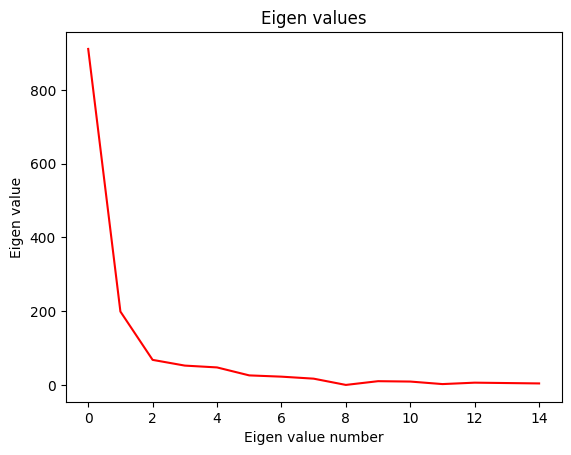

In [9]:
# 固有値をプロット -> エルボー則によりmを決定する
plt.plot(range(len(evd)), evd, color="red")
plt.title("Eigen values")
plt.xlabel("Eigen value number")
plt.ylabel("Eigen value")
plt.show()

固有値の計算の結果、『エルボー則』によれば、$m=2$でよさそうと判断します。(エルボー則: ひじのように急激な屈曲を目安にするもの)

In [10]:
# データクレンジングのため、訓練データに対して異常度を計算
m = 2                       # プロットの結果から、エルボー則により決定
x2 = v[:,0:m].T.dot(Xc)     # 正常部分空間内の成分を計算
a1 = (Xc * Xc).sum(axis=0) - (x2 * x2).sum(axis=0)  # 異常度を全訓練標本に対し計算

異常度の高い６つの車種を選ぶ。

In [12]:
# 異常度上位6つを出力
result = pd.DataFrame({ "name": df["Make"], "a": a1 })
print(result.sort_values(by='a', ascending=False)[:6])

                  name          a
18  Chevrolet Corvette  13.595830
41         Honda Civic  11.829742
38           Geo Metro  11.156367
58  Mercedes-Benz 300E  10.586025
88  Volkswagen Eurovan   9.971148
27       Dodge Stealth   8.727322


Chevrolet Corvetteは、高価・小型・高出力という点で特徴的なスポーツカー。  
Honda Civicは同クラスの自動車に比べて、比較的安価で、かつ顕著に燃費が良いという特徴がある。  
Geo Metroは非常に安価で、小出力・高燃費という特徴がある。そうです。  

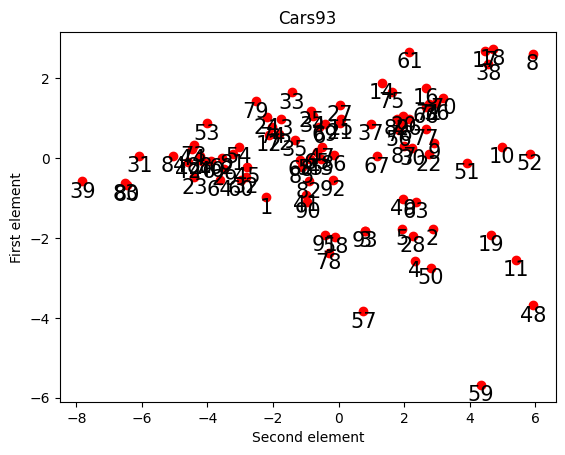

In [13]:
# Car93データの正常部分空間における分布をプロット
plt.scatter(x2[0,:], x2[1,:], color="red")
for i in range(len(x2[0,:])):
    plt.text(x2[0,i], x2[1,i], i+1, ha="center", va="top", size=15)
plt.title("Cars93")
plt.xlabel("Second element")
plt.ylabel("First element")
plt.show()

高次元データを扱う際、主成分分析を用いてデータの分布の可視化をすることがよくある。  
Corvette, Civic, Metroはそれぞれ、19, 42, 39に対応している。Metroは別として、Corvette, Civicは特に外れ値ではないことがわかる。  
この点は、可視化結果の解釈の上でも実用上、非常に重要。すなわち、主部分空間内で異常に見えなかったとしても、  
実際には異常標本であるということが頻繁に起こる。

### 正定値カーネルの直感的理解

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn import svm
from sklearn.svm import LinearSVC

In [15]:
np.random.seed(0)
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 500), np.linspace(-1.5, 1.5, 500))

In [16]:
X, y = make_circles(n_samples=400, factor=.3, noise=.05)
# 線形サポートベクトルマシン
linear_svc = LinearSVC(random_state=0)
# ガウスカーネルサポートベクトルマシン
rbf_svc = svm.SVC(kernel='rbf')
rbf_svc.fit(X, y)
linear_svc.fit(X, y)

LinearSVC(random_state=0)

In [18]:
# plot the line, the points, and the nearest vectors to the plane
Z = rbf_svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

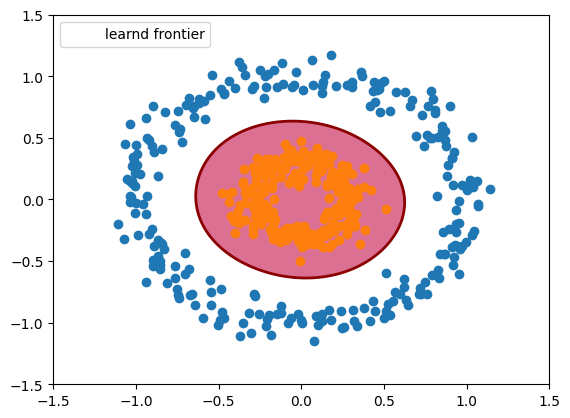

In [19]:
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')

X, y = make_circles(n_samples=500, factor=.3, noise=.08)
y_rbf = rbf_svc.predict(X)
plt.scatter(X[y_rbf==0,0],X[y_rbf==0,1])
plt.scatter(X[y_rbf==1,0],X[y_rbf==1,1])

plt.legend([a.collections[0]],
           ["learnd frontier"],
           loc="upper left",)

### カーネル主成分分析のサンプル

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

In [21]:
np.random.seed(0)

X, y = make_circles(n_samples=400, factor=.3, noise=.05)

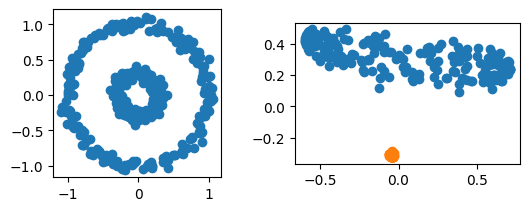

In [22]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)

plt.subplot(2, 2, 1, aspect='equal')
plt.scatter(X[:,0],X[:,1])

plt.subplot(2, 2, 2, aspect='equal')
plt.scatter(X_kpca[y==1,0],X_kpca[y==1,1])
plt.scatter(X_kpca[y==0,0],X_kpca[y==0,1])

右側の標本を次元圧縮した結果が、左側の図

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

#from sklearn.datasets.samples_generator import make_swiss_roll
from sklearn.datasets import make_swiss_roll

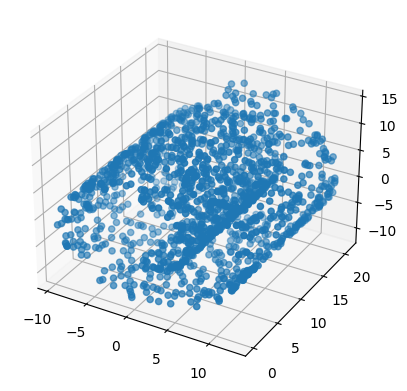

In [28]:
np.random.seed(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, _ = make_swiss_roll(n_samples=1500, noise=0.05)

# 元のスイスロールを描画
ax.scatter(X[:,0],X[:,1],X[:,2])

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=2)
X_kpca = kpca.fit_transform(X)

#ax.scatter(X_kpca[:,0],X_kpca[:,1])

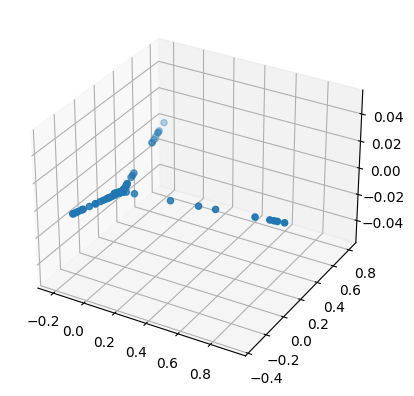

In [29]:
# 元のスイスロールを描画
#ax.scatter(X[:,0],X[:,1],X[:,2])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, _ = make_swiss_roll(n_samples=1500, noise=0.05)

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=2)
X_kpca = kpca.fit_transform(X)

ax.scatter(X_kpca[:,0],X_kpca[:,1])

**カーネル主成分分析によって次元削減されたもの**